In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from ta import *
from xgboost import XGBClassifier
from gpboost import GPBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('AAPL.csv')

In [3]:
def apply_npmm_labeling(df, column_name='Close', window_size=10):
    df['Label'] = None
    for i in range(0, len(df) - window_size + 1):
        window = df.loc[i:i+window_size-1, column_name]
        local_max = window.max()
        local_min = window.min()
        max_index = window[window == local_max].index[0]
        min_index = window[window == local_min].index[0]

        df.loc[max_index, 'Label'] = 0  
        df.loc[min_index, 'Label'] = 1 

    return df


labeled_df = apply_npmm_labeling(data, 'Close', 14)

In [4]:
all_ti = add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

c:\Users\bhatn\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
c:\Users\bhatn\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
c:\Users\bhatn\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
c:\Users\bhatn\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated an

In [5]:
labeled_df = apply_npmm_labeling(all_ti, 'Close', 14)

In [6]:
X = labeled_df.drop(['Label', 'Date'], axis=1).values
y = labeled_df.Label.fillna(2).values

In [8]:
labeled_df

,Date,Open,High,Low,Close,Adj Close,Volume,Label,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800,None,4.800521e+08,535796800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999442,-96.663656,0.000000,0.000000
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600,None,1.101937e+08,23419200,...,-0.676785,-0.135357,-0.541428,-0.349809,-0.069962,-0.279847,0.960701,-8.431001,-8.807741,-8.431001
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600,None,-4.623029e+08,801740800,...,-1.097043,-0.327694,-0.769349,3.242622,0.592555,2.650067,0.945949,1.463317,1.452714,-7.091056
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800,None,-1.230276e+09,33768000,...,-2.081646,-0.678485,-1.403161,5.696818,1.613408,4.083411,0.899108,-8.653837,-9.051390,-15.131245
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400,None,-1.020855e+09,494502400,...,-2.509529,-1.044693,-1.464835,3.359334,1.962593,1.396741,0.894199,4.736896,4.628127,-11.111100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,1,7.898003e+10,100842500500,...,-2.613749,-1.812204,-0.801545,0.675589,1.688666,-1.013077,138.133261,-0.279812,-0.280204,13093.362204
5783,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800,1,7.897824e+10,100773492700,...,-2.818298,-2.013423,-0.804875,-0.714236,1.208086,-1.922322,136.508708,-1.387837,-1.397557,12910.259846
5784,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,1,7.889843e+10,100688054300,...,-3.186055,-2.247949,-0.938105,-0.186269,0.929215,-1.115484,133.686346,-3.068521,-3.116586,12511.037286
5785,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.059372,75703700,None,7.892623e+10,100763758000,...,-3.232034,-2.444766,-0.787268,-0.729272,0.597517,-1.326789,133.136190,2.832434,2.793062,12868.236579


In [9]:
labeled_df.to_csv('ta_included.csv')

190

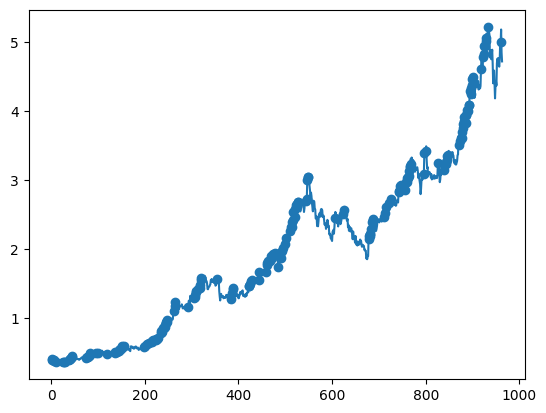

In [367]:
tscv = TimeSeriesSplit(n_splits=5)
clf = XGBClassifier(gamma = 10, max_depth = 10, tree_method = 'hist')
i, (train_index, test_index) = next(enumerate(tscv.split(X)))
sample_weights = compute_sample_weight(
    class_weight= 'balanced',
    y=y[train_index] #provide your own target name
)
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
clf.fit(X[train_index], y[train_index], sample_weight=sample_weights)
yh = clf.predict_proba(X[test_index])
trade_possible = yh.prod(axis = 1) < 0.01
# plt.scatter(x = range(0, X_test[:,0].shape[0]), y = X_test[:,0], color = yh)
plt.plot(X_test[:,0])
txt = X_test[trade_possible,0]
plt.scatter(x = np.arange(0, X_test.shape[0])[trade_possible], y = txt)
sum(trade_possible)

In [283]:


sample_weights = compute_sample_weight(
    class_weight={0: 1, 1: 1, 2: 0.01},
    y=y #provide your own target name
)
clf = XGBClassifier(gamma = 10, max_depth = 10, tree_method = 'hist')
tscv = TimeSeriesSplit(n_splits=5)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    clf.fit(X[train_index], y[train_index], sample_weight=sample_weights[train_index])
    test_inds = y[test_index]
    true_test = (test_inds == 1) | (test_inds == 0)
    true_train = (y[train_index] == 1) | (y[train_index] == 0)
    print(clf.score(X[test_index][true_test], y[test_index][true_test]), clf.score(X[train_index][true_train], y[train_index][true_train]))

0.6905187835420393 0.7808764940239044
0.7050359712230215 0.7737983034872762
0.7042513863216266 0.7588126159554731
0.6898395721925134 0.7571825764596849
0.7100694444444444 0.7392423685178374
